In [1]:
import torch
import numpy as np
from data import TSdataset
from model import model, utils
from sklearn.manifold import TSNE
import torcheval.metrics.functional as F

In [4]:
data = TSdataset.GetData('./data/Floatation', 4, 60, None)

net = model.DSSLTS(data.getInputShape[1],
                   64,
                   60,
                   1,
                   data.getInputShape[1],
                   128,
                   1,
                   1,
                   1e-4,
                   22,
                   0.22)
net.SSLnet = torch.load('./save/exp1/sslnet.pt')
net.predNet = torch.load('./save/exp1/prednet.pt')
net.time_adj = torch.load('./save/exp1/time_adj.pt')
net.to('cuda')

d:\Files\Phd\Floatation\2023.4.20FewShotLearning\Code\model\model.py:111: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  result = result @ edge_index - result + eye_m


In [8]:

mus = None
stds = None
labels = None
dataloader = data.getAllTestDataloader

with torch.no_grad():
    for item in data.seq_test_dataset:
        x, ySL, _, _ = item
        x = x.to('cuda')
        x = x.reshape(-1, 3, 256, 256) 
        hidden = net.SSLnet.encoder(x)
        mu = net.SSLnet.fc(hidden)[:,:64] # [batch_size, num_nodes, latent_dim]
        log_std = net.SSLnet.fc(hidden)[:,64:] # [batch_size, num_nodes, latent_dim]
        mus = utils.ts_append(mus, mu)
        stds = utils.ts_append(stds, log_std)
        labels = utils.ts_append(labels, ySL)
tsne_center = TSNE(n_components=2, init='pca', random_state=0)
tsne_width = TSNE(n_components=1, init='pca', random_state=0)
mus = mus[:,0,:]
stds = stds[:,0,:]
labels = labels[:,0]
# labels = (labels - labels.min()) / (labels.max() - labels.min()).numpy()
centers = tsne_center.fit_transform(mus.cpu().numpy())
widths = tsne_width.fit_transform(stds.cpu().numpy())

d:\Apps\Anaconda\Anaconda\envs\GNN\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


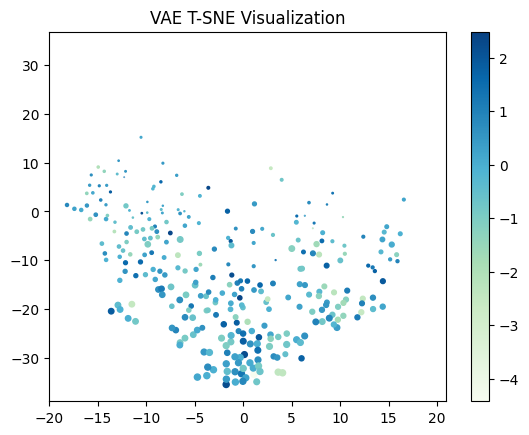

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(centers[:,0], centers[:,1], s=widths, c=labels, marker='o', cmap='GnBu')
plt.colorbar()
plt.title('VAE T-SNE Visualization')
plt.show()

In [15]:
ySLAll = None
outAll = None
maskAll = None
dataloader = data.getAllTestDataloader

with torch.no_grad():
    for item in data.seq_test_dataset:
        x, ySL, mask, _ = item
        x = x.to('cuda').unsqueeze(0)
        ySL = ySL.to('cuda')
        mask = mask.to('cuda')
        output = net.predictor(x)
        outAll = utils.ts_append(outAll, output)
        maskAll = utils.ts_append(maskAll, mask)
        ySLAll = utils.ts_append(ySLAll, ySL)
outAll = utils.lb_denormalize(outAll)
outAll = outAll.squeeze(1)
ySLAll = utils.lb_denormalize(ySLAll)
maskAll = ~maskAll
pred = torch.masked_select(outAll, maskAll).cpu().numpy()
target = torch.masked_select(ySLAll, maskAll).cpu().numpy()
np.savetxt('./save/pred.txt', pred)
np.savetxt('./save/target.txt', target)

In [3]:
def dot_structure(x, edge_index, net):
    x = x.squeeze(0)
    hidden = net.SSLnet.encoder(x)
    dict = hidden[edge_index[0],:]*hidden[edge_index[1],:]
    dict = dict.sum(dim=1)
    min_v = torch.min(x)
    max_v = torch.max(x)
    dict = (dict - min_v) / (max_v - min_v)
    return dict

def dot_predcior(x, net):
    source = torch.tensor(range(x.shape[1])).repeat(1, x.shape[1])
    target = torch.tensor(range(x.shape[1])).unsqueeze(1).repeat(1, x.shape[1]).flatten().unsqueeze(0)
    edge = torch.cat((source, target), dim=0).to(x.device)
    edge_attr = None
    for i in range(x.shape[0]):
        edge_attr = utils.ts_append(edge_attr, dot_structure(x[i], edge, net))
    input = net.SSLnet.embedding(x).reshape(x.shape[0], x.shape[1], -1)

    output = net.predNet(input, net.time_adj.to(x.device), edge, edge_attr)

    return output

In [4]:
def cos_structure(x, edge_index, net):
    x = x.squeeze(0)
    hidden = net.SSLnet.encoder(x)
    dict = torch.cosine_similarity(hidden[edge_index[0],:], hidden[edge_index[1],:])
    return dict

def cos_predictor(x, net):
    source = torch.tensor(range(x.shape[1])).repeat(1, x.shape[1])
    target = torch.tensor(range(x.shape[1])).unsqueeze(1).repeat(1, x.shape[1]).flatten().unsqueeze(0)
    edge = torch.cat((source, target), dim=0).to(x.device)
    edge_attr = None
    for i in range(x.shape[0]):
        edge_attr = utils.ts_append(edge_attr, cos_structure(x[i], edge, net))
    input = net.SSLnet.embedding(x).reshape(x.shape[0], x.shape[1], -1)

    output = net.predNet(input, net.time_adj.to(x.device), edge, edge_attr)
    
    return output

In [5]:
ySLAll = None
vae_out_all = None
dot_out_all = None
cos_out_all = None
maskAll = None

with torch.no_grad():
    for item in data.seq_test_dataset:
        x, ySL, mask, _ = item
        x = x.to('cuda').unsqueeze(0)
        ySL = ySL.to('cuda')
        mask = mask.to('cuda')
        vae_out = net.predictor(x)
        dot_out = dot_predcior(x, net)
        cos_out = cos_predictor(x, net)
        vae_out_all = utils.ts_append(vae_out_all, vae_out)
        dot_out_all = utils.ts_append(dot_out_all, dot_out)
        cos_out_all = utils.ts_append(cos_out_all, cos_out)
        maskAll = utils.ts_append(maskAll, mask)
        ySLAll = utils.ts_append(ySLAll, ySL)
vae_out_all = utils.lb_denormalize(vae_out_all)
vae_out_all = vae_out_all.squeeze(1)
dot_out_all = utils.lb_denormalize(dot_out_all)
dot_out_all = dot_out_all.squeeze(1)
cos_out_all = utils.lb_denormalize(cos_out_all)
cos_out_all = cos_out_all.squeeze(1)
ySLAll = utils.lb_denormalize(ySLAll)      

In [6]:
mae_fn = torch.nn.L1Loss()
vae_mae = mae_fn(torch.masked_select(vae_out_all, maskAll), torch.masked_select(ySLAll, maskAll)).item()
vae_rmse = torch.sqrt(F.mean_squared_error(torch.masked_select(ySLAll, maskAll), torch.masked_select(vae_out_all, maskAll))).item()
vae_r2_score = F.r2_score(torch.masked_select(vae_out_all, maskAll), torch.masked_select(ySLAll, maskAll)).item()
print("VAE Result: MAE:", vae_mae, " RMSE: ", vae_rmse, " R2: ", vae_r2_score)

dot_mae = mae_fn(torch.masked_select(dot_out_all, maskAll), torch.masked_select(ySLAll, maskAll)).item()
dot_rmse = torch.sqrt(F.mean_squared_error(torch.masked_select(ySLAll, maskAll), torch.masked_select(dot_out_all, maskAll))).item()
dot_r2_score = F.r2_score(torch.masked_select(dot_out_all, maskAll), torch.masked_select(ySLAll, maskAll)).item()
print("DOT Product Result: MAE:", dot_mae, " RMSE: ", dot_rmse, " R2: ", dot_r2_score)

cos_mae = mae_fn(torch.masked_select(cos_out_all , maskAll), torch.masked_select(ySLAll, maskAll)).item()
cos_rmse = torch.sqrt(F.mean_squared_error(torch.masked_select(ySLAll, maskAll), torch.masked_select(cos_out_all , maskAll))).item()
cos_r2_score = F.r2_score(torch.masked_select(cos_out_all , maskAll), torch.masked_select(ySLAll, maskAll)).item()
print("COSINE Result: MAE:", cos_mae, " RMSE: ", cos_rmse, " R2: ", cos_r2_score)

VAE Result: MAE: 0.9166648387908936  RMSE:  1.1927697658538818  R2:  -0.0007266998291015625
DOT Product Result: MAE: 0.9166648387908936  RMSE:  1.1927697658538818  R2:  -0.0007266998291015625
COSINE Result: MAE: 0.9166648387908936  RMSE:  1.1927697658538818  R2:  -0.0007266998291015625


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))
plt.rcParams["figure.autolayout"] = True